(a) Visualize the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def show_image(list_of_images):
  for i in list_of_images:
    plt.figure()
    plt.imshow(i)

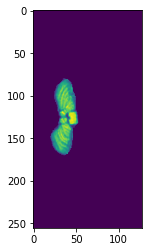

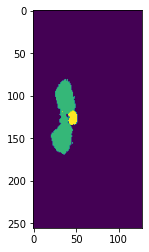

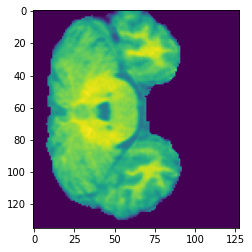

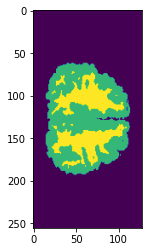

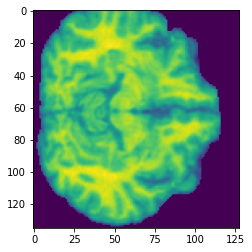

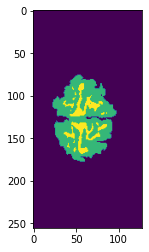

In [ ]:
import scipy.io as spio
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from scipy import io
import numpy as np
from torch.utils import data

%matplotlib inline

path = '/content/drive/My Drive/dataset_brain/'
data1 = spio.loadmat(path + 'Vol_01_input.mat')
data1_labels = spio.loadmat(path + 'Vol_01gt.mat')

data2 = spio.loadmat(path + 'Vol_02_input.mat')
data2_labels = spio.loadmat(path + 'Vol_02gt.mat')

data3 = spio.loadmat(path + 'Vol_05_input.mat')
data3_labels = spio.loadmat(path + 'Vol_05gt.mat')

data4 = spio.loadmat(path + 'Vol_09_input.mat')
data4_labels = spio.loadmat(path + 'Vol_09gt.mat')

test_data = spio.loadmat(path + 'Vol_06_input.mat')
test_data_labels = spio.loadmat(path + 'Vol_06gt.mat')

# the input mats(ana) is the image and the gt mat is the labels
np_data1 = np.array(data1['ana'])[65:200,:,:]
np_data1_labels = np.array(data1_labels['gt'])[:,:,65:200]

np_data2 = np.array(data2['ana'])[:,:,65:200]
np_data2_labels = np.array(data2_labels['gt'])[:,:,65:200]

np_data3 = np.array(data3['ana'])[:,:,65:200]
np_data3_labels = np.array(data3_labels['gt'])[:,:,65:200]

np_data4 = np.array(data4['ana'])[:,:,65:200]
np_data4_labels = np.array(data4_labels['gt'])[:,:,65:200]

test_np_data = np.array(test_data['ana'])[:,:,65:200]
test_np_data_labels = np.array(test_data_labels['gt'])[:,:,65:200]

# print(np.min(np_data1_labels))
# end
top = 10
mid = 100
# top
end = 120
# tensor_data = torch.Tensor(np_data)
ims = [np_data4[:,:,top], np_data4_labels[:,:,top], np_data1[:,:,mid], np_data1_labels[:,:,mid], np_data1[:,:,end], np_data1_labels[:,:,end]]
show_image(ims)

Baseline model.

Transpose convolution, maxpool

In [ ]:
class FCN_2(nn.Module):
  def __init__(self, class_num):
    super(FCN_2, self).__init__()
    # implemented using architecture of VGG16 and FCN in the orignal paper
    # conv -> in_channel, out_channel, kernel_size
    # pool -> kernel_size, stride
    self.relu = nn.ReLU(inplace=True)
    self.c11 = nn.Conv2d(1, 64, 3, padding = 1)
    self.c12 = nn.Conv2d(64, 64, 3, padding = 1)
    self.p1 = nn.MaxPool2d(2, 2)
    self.c21 = nn.Conv2d(64, 128, 3, padding = 1)
    self.c22 = nn.Conv2d(128, 128, 3, padding = 1)
    self.p2 = nn.MaxPool2d(2, 2)
    self.c31 = nn.Conv2d(128, 256, 3, padding = 1)
    self.c32 = nn.Conv2d(256, 256, 3, padding = 1)  
    self.c33 = nn.Conv2d(256, 256, 3, padding = 1)
    self.p3 = nn.MaxPool2d(2, 2)
    self.c41 = nn.Conv2d(256, 512, 3, padding = 1)
    self.c42 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c43 = nn.Conv2d(512, 512, 3, padding = 1)
    # padding = 1
    self.p4 = nn.MaxPool2d(2, 2)
    self.c51 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c52 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c53 = nn.Conv2d(512, 512, 3, padding = 1)
    self.p5 = nn.MaxPool2d(2, 2)
    self.c60 = nn.Conv2d(512, 4096, 7, padding = 3)
    self.d1 = nn.Dropout(0.85)
    self.c70 = nn.Conv2d(4096, 4096, 1)
    self.d2 = nn.Dropout(0.85)
    self.c8 = nn.Conv2d(4096, class_num, 1)
    # self.up_inter
    self.trans1 = nn.ConvTranspose2d(class_num, 512, 4, 2, 1)
    self.trans2 = nn.ConvTranspose2d(512, 256, 4, 2, 1) 
    self.trans3 = nn.ConvTranspose2d(256, class_num, 16, 8, 4)

  def forward(self, x):
    x = self.relu(self.c12(self.relu(self.c11(x))))
    x = self.p1(x)
    x = self.p2(self.relu(self.c22(self.relu(self.c21(x)))))
    # print(x.shape)
    x1 = self.p3(self.relu(self.c33(self.relu(self.c32(self.relu(self.c31(x)))))))
    x2 = self.p4(self.relu(self.c43(self.relu(self.c42(self.relu(self.c41(x1)))))))
    x = self.p5(self.relu(self.c53(self.relu(self.c52(self.relu(self.c51(x2)))))))
    x = self.d1(self.relu(self.c60(x)))
    x = self.d2(self.relu(self.c70(x)))
    x = self.relu(self.c8(x))
    x = self.trans1(x)
    x = self.trans2(x)
    x = self.trans3(x)
    # print(x.shape)
    return x


strided convolution

In [ ]:
class FCN_3(nn.Module):
  def __init__(self, class_num):
    super(FCN_3, self).__init__()
    # implemented using architecture of VGG16 and FCN in the orignal paper
    # conv -> in_channel, out_channel, kernel_size
    # pool -> kernel_size, stride
    self.relu = nn.ReLU(inplace=True)
    self.c11 = nn.Conv2d(1, 64, 3, padding = 1)
    self.c12 = nn.Conv2d(64, 64, 3, padding = 1)
    self.p1 = nn.Conv2d(64, 64, 2, 2)
    self.c21 = nn.Conv2d(64, 128, 3, padding = 1)
    self.c22 = nn.Conv2d(128, 128, 3, padding = 1)
    self.p2 = nn.Conv2d(128, 128, 2, 2)
    self.c31 = nn.Conv2d(128, 256, 3, padding = 1)
    self.c32 = nn.Conv2d(256, 256, 3, padding = 1)  
    self.c33 = nn.Conv2d(256, 256, 3, padding = 1)
    self.p3 = nn.Conv2d(256, 256, 2, 2)
    self.c41 = nn.Conv2d(256, 512, 3, padding = 1)
    self.c42 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c43 = nn.Conv2d(512, 512, 3, padding = 1)
    # padding = 1
    self.p4 = nn.Conv2d(512, 512, 2, 2)
    self.c51 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c52 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c53 = nn.Conv2d(512, 512, 3, padding = 1)
    self.p5 = nn.Conv2d(512, 512, 2, 2)
    self.c60 = nn.Conv2d(512, 4096, 7, padding = 3)
    self.d1 = nn.Dropout(0.85)
    self.c70 = nn.Conv2d(4096, 4096, 1)
    self.d2 = nn.Dropout(0.85)
    self.c8 = nn.Conv2d(4096, class_num, 1)
    # self.up_inter
    self.trans1 = nn.ConvTranspose2d(class_num, 512, 4, 2, 1)
    self.trans2 = nn.ConvTranspose2d(512, 256, 4, 2, 1) 
    self.trans3 = nn.ConvTranspose2d(256, class_num, 16, 8, 4)

  def forward(self, x):
    x = self.relu(self.c12(self.relu(self.c11(x))))
    x = self.p1(x)
    x = self.p2(self.relu(self.c22(self.relu(self.c21(x)))))
    # print(x.shape)
    x1 = self.p3(self.relu(self.c33(self.relu(self.c32(self.relu(self.c31(x)))))))
    x2 = self.p4(self.relu(self.c43(self.relu(self.c42(self.relu(self.c41(x1)))))))
    x = self.p5(self.relu(self.c53(self.relu(self.c52(self.relu(self.c51(x2)))))))
    x = self.d1(self.relu(self.c60(x)))
    x = self.d2(self.relu(self.c70(x)))
    x = self.relu(self.c8(x))
    x = self.trans1(x)
    x = self.trans2(x)
    x = self.trans3(x)
    # print(x.shape)
    return x


Model Encoder : maxpool
, Decoder : Transposed Convolution
with 2 skip connections

In [ ]:
class FCN(nn.Module):
  def __init__(self, class_num):
    super(FCN, self).__init__()
    # implemented using architecture of VGG16 and FCN in the orignal paper
    # conv -> in_channel, out_channel, kernel_size
    # pool -> kernel_size, stride
    self.relu = nn.ReLU(inplace=True)
    self.c11 = nn.Conv2d(1, 64, 3, padding = 1)
    self.c12 = nn.Conv2d(64, 64, 3, padding = 1)
    self.p1 = nn.MaxPool2d(2, 2)
    self.c21 = nn.Conv2d(64, 128, 3, padding = 1)
    self.c22 = nn.Conv2d(128, 128, 3, padding = 1)
    self.p2 = nn.MaxPool2d(2, 2)
    self.c31 = nn.Conv2d(128, 256, 3, padding = 1)
    self.c32 = nn.Conv2d(256, 256, 3, padding = 1)  
    self.c33 = nn.Conv2d(256, 256, 3, padding = 1)
    self.p3 = nn.MaxPool2d(2, 2)
    self.c41 = nn.Conv2d(256, 512, 3, padding = 1)
    self.c42 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c43 = nn.Conv2d(512, 512, 3, padding = 1)
    # padding = 1
    self.p4 = nn.MaxPool2d(2, 2)
    self.c51 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c52 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c53 = nn.Conv2d(512, 512, 3, padding = 1)
    self.p5 = nn.MaxPool2d(2, 2)
    self.c60 = nn.Conv2d(512, 4096, 7, padding = 3)
    self.d1 = nn.Dropout(0.85)
    self.c70 = nn.Conv2d(4096, 4096, 1)
    self.d2 = nn.Dropout(0.85)
    self.c8 = nn.Conv2d(4096, class_num, 1)
    # self.up_inter
    self.trans1 = nn.ConvTranspose2d(class_num, 512, 4, 2, 1)
    self.trans2 = nn.ConvTranspose2d(512, 256, 4, 2, 1) 
    self.trans3 = nn.ConvTranspose2d(256, class_num, 16, 8, 4)

  def forward(self, x):
    # print(x.shape)
    x = self.relu(self.c12(self.relu(self.c11(x))))
    x = self.p1(x)
    x = self.p2(self.relu(self.c22(self.relu(self.c21(x)))))
    # print(x.shape)
    x1 = self.p3(self.relu(self.c33(self.relu(self.c32(self.relu(self.c31(x)))))))
    x2 = self.p4(self.relu(self.c43(self.relu(self.c42(self.relu(self.c41(x1)))))))
    x = self.p5(self.relu(self.c53(self.relu(self.c52(self.relu(self.c51(x2)))))))
    x = self.d1(self.relu(self.c60(x)))
    x = self.d2(self.relu(self.c70(x)))
    x = self.relu(self.c8(x))
    x = self.trans1(x)
    # print(x.shape)
    x = x2 + x
    x = self.trans2(x)
    # print(x.shape)
    # print(x1.shape)
    x = x1 + x
    x = self.trans3(x)
    # print(x.shape)
    return x


Model max pool, interpolation

In [ ]:
class FCN_1(nn.Module):
  def __init__(self, class_num):
    super(FCN_1, self).__init__()
    # implemented using architecture of VGG16 and FCN in the orignal paper
    # conv -> in_channel, out_channel, kernel_size
    # pool -> kernel_size, stride
    self.class_num = class_num
    self.relu = nn.ReLU(inplace=True)
    self.c11 = nn.Conv2d(1, 64, 3, padding = 1)
    self.c12 = nn.Conv2d(64, 64, 3, padding = 1)
    self.p1 = nn.MaxPool2d(2, 2)
    self.c21 = nn.Conv2d(64, 128, 3, padding = 1)
    self.c22 = nn.Conv2d(128, 128, 3, padding = 1)
    self.p2 = nn.MaxPool2d(2, 2)
    self.c31 = nn.Conv2d(128, 256, 3, padding = 1)
    self.c32 = nn.Conv2d(256, 256, 3, padding = 1)  
    self.c33 = nn.Conv2d(256, 256, 3, padding = 1)
    self.p3 = nn.MaxPool2d(2, 2)
    self.c41 = nn.Conv2d(256, 512, 3, padding = 1)
    self.c42 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c43 = nn.Conv2d(512, 512, 3, padding = 1)
    # padding = 1
    self.p4 = nn.MaxPool2d(2, 2)
    self.c51 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c52 = nn.Conv2d(512, 512, 3, padding = 1)
    self.c53 = nn.Conv2d(512, 512, 3, padding = 1)
    self.p5 = nn.MaxPool2d(2, 2)
    self.c60 = nn.Conv2d(512, 4096, 7, padding = 3)
    self.d1 = nn.Dropout(0.85)
    self.c70 = nn.Conv2d(4096, 4096, 1)
    self.d2 = nn.Dropout(0.85)
    self.c8 = nn.Conv2d(4096, class_num, 1)

  def forward(self, x):
    siz1 = list(x.size())
    a, b, c = siz1[0], siz1[2], siz1[3]
    x = self.relu(self.c12(self.relu(self.c11(x))))
    x = self.p1(x)
    x = self.p2(self.relu(self.c22(self.relu(self.c21(x)))))
    x1 = self.p3(self.relu(self.c33(self.relu(self.c32(self.relu(self.c31(x)))))))
    x2 = self.p4(self.relu(self.c43(self.relu(self.c42(self.relu(self.c41(x1)))))))
    x = self.p5(self.relu(self.c53(self.relu(self.c52(self.relu(self.c51(x2)))))))
    x = self.d1(self.relu(self.c60(x)))
    x = self.d2(self.relu(self.c70(x)))
    x = self.relu(self.c8(x))
    x = nn.functional.interpolate(x, size = ( int(b/4), int(c/4)))
    x = nn.functional.interpolate(x, size = (int(b/2), int(c/2)))
    x = nn.functional.interpolate(x, size = (b, c))
    return x

In [ ]:
def lister(x):
    sh = x.shape[2]
    py_list = []
    for i in range(sh):
      yy = x[:,:,i]
      yy_flip = np.flip(yy, axis = 1)
      yy_flip = yy_flip[np.newaxis, ...]
      yy = yy[np.newaxis, ...]
      # print(yy.shape)
      # print(yy_flip.shape)
      py_list.append(yy)
      py_list.append(yy_flip)
    return py_list
    

In [ ]:
def cropper(ll):
  dim1 = ll.shape[0]
  dim2 = ll.shape[1]
  dim1 = int(dim1/2)
  dim2 = int(dim2/2)
  # print(dim1)
  # print(dim2)
  np1 = ll[:dim1,:dim2,:]
  np2 = ll[dim1 : ,:dim2,:]
  np3 = ll[:dim1,dim2 : ,:]
  np4 = ll[dim1 :,dim2 : ,:]
  py = (np1, np2, np3, np4)
  out = np.concatenate(py, axis = 2)
  # print(out.shape)
  return lister(out)

In [ ]:
d1 = cropper(np_data1)
dl1 = cropper(np_data1_labels)
d2 = cropper(np_data2)
dl2 = cropper(np_data2_labels)
d3 = cropper(np_data3)
dl3 = cropper(np_data3_labels)
# t_nit = cropper(test_np_data)
# t_nitl = cropper(test_np_data_labels)

test = lister(test_np_data)
testl = lister(test_np_data_labels)

tt1 = lister(np_data4)
tt1_l = lister(np_data4_labels)

d1.extend(d2)
d1.extend(d3)
# d1.extend(t_nit) 
dl1.extend(dl2)
dl1.extend(dl3)
# dl1.extend(t_nitl)

t1 = torch.Tensor(d1).cuda()
t1l = torch.Tensor(dl1).cuda()

print(t1.size())

test1 = torch.Tensor(test).cuda()
testl1 = torch.Tensor(testl).cuda()

test_tt1 = torch.Tensor(tt1).cuda()
testl_tt1 = torch.Tensor(tt1_l).cuda()

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.size(0)

  def __getitem__(self, index):
        'Generates one sample of data'
        return self.X[index, :, :, :], self.y[index, :, :, :]

my_dataset = Dataset(t1,t1l)
my_dataloader = data.DataLoader(my_dataset, batch_size = 10)

torch.Size([3240, 1, 128, 64])


Train the model

In [ ]:
def save(model, path):
  torch.save(model.state_dict(), path)

In [ ]:
def load(md, path):
  md.load_state_dict(torch.load(path))
  md.eval()

In [ ]:
# use_cuda = torch.cuda.is_available()
lr = 0.001
momentum = 0.9
epochs = 1000

name = 'FCN'
model = FCN(4)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), momentum = momentum, lr=lr)
# optimizer = optim.Adam(model.parameters(), lr=lr)


losses = list()

for ep in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(my_dataloader, 0):
    # get the inputs
    inputs, labels = data

    # wrap them in Variable
    inputs = Variable(inputs.cuda())
    labels = Variable(labels.cuda())

    # zero the parameter gradients
    optimizer.zero_grad()
    outputs = model(inputs)

    lb = torch.squeeze(labels)
    loss = criterion(outputs, lb.long())
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 200 == 0:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %f' % (ep + 1, i + 1, loss.item()))
        losses.append(loss.item())


print('Finished Training')
save(model, path + name + '_model.pt')
plt.plot(losses)

[1,     1] loss: 1.402365


KeyboardInterrupt: ignored

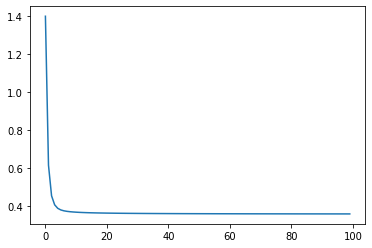

In [ ]:
# save(model, path + name + '_model.pt')
plt.plot(losses[::2])


Test the code

In [ ]:
from keras import backend as K

def dice_coeff(y_pred, y_true):
    smooth = 1.
    y_pred = K.cast(y_pred, 'int32')
    y_true = K.cast(y_true, 'int32')
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(K.one_hot(K.cast(y_pred, 'int32'), num_classes=4)[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.eval(K.mean((2. * intersect / (denom + smooth))))

Using TensorFlow backend.


In [ ]:
from mlxtend.plotting import plot_confusion_matrix

def print_cm(cm,title):
    classes = [0, 1, 2, 3]
    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                    colorbar=True,
                                    show_absolute=True,
                                    show_normed=False)
    fig.set_figheight(7)
    fig.set_figwidth(7)
    ax.set(xticklabels=classes)
    plt.title("confusion matrix for " + str(title))
    plt.show()


dice coeff : 0.6231785


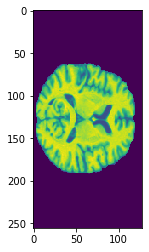

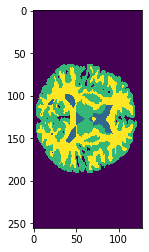

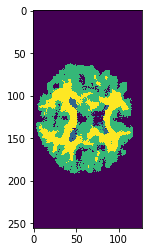

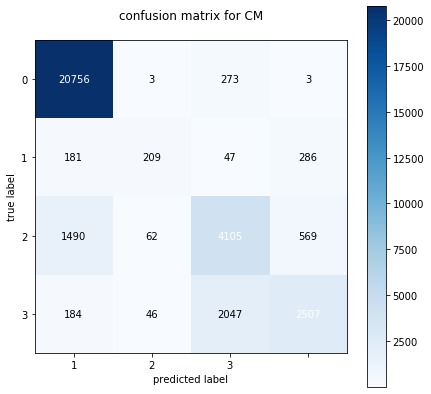

In [ ]:
from sklearn.metrics import confusion_matrix
from torch.utils import data

my_testdataset = Dataset(test_tt1,testl_tt1)
my_testdataloader = data.DataLoader(my_testdataset, batch_size = 20)

model = FCN(4)
model.load_state_dict(torch.load(path + 'model1.pt'))
model.eval()
model = model.cuda()

# dice_coeff = 0.0
preds = None
for i, data in enumerate(my_testdataloader, 0):
    inps, _ = data
    inps = Variable(inps.cuda())
    outs = model(inps)

    _, ps = torch.max(outs, 1)
    ps = ps.data.cpu().numpy()

    if preds is None:
      preds = ps
    else:
      preds = np.vstack((preds, ps))

idx = 150
a = torch.squeeze(testl1).cpu().numpy()
b = torch.squeeze(test1).cpu().numpy()

show_image([b[idx,:,:], a[idx,:,:], preds[idx, :, :]])

mx = preds.shape[0]

print("dice coeff : " + str(dice_coeff(preds[idx, :, :], a[idx,:,:])))


aa = a[idx,:,:].flatten()
bb = preds[idx,:,:].flatten()
cm = confusion_matrix(aa, bb)
print_cm(cm,"CM")